В датасете стоит задача определения воздушных рейсов, которые задержат свой вылет, что выжно для устойчивости логистических цепочек и избежания опасных ситуаций. Данные содержат информацию про самолет(количество мест, срок службы, компания владелец), погоду(общее количество осадков, количество выпавшего снега, количество снега, который выпадет за день, максимальную температуру в течение дня, максимальная скорость ветра в течение дня), информацию об аэропорте(название, широта и долгота, среднее количество вылетов в месяц)

Чтение данных и приведение категориальных признаков к числовым значениям

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_predict, cross_val_score, cross_validate
from imblearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report


In [6]:
data = pd.read_csv('data/full_data_flightdelay.csv')
data


,MONTH,DAY_OF_WEEK,DEP_DEL15,DEP_TIME_BLK,DISTANCE_GROUP,SEGMENT_NUMBER,CONCURRENT_FLIGHTS,NUMBER_OF_SEATS,CARRIER_NAME,AIRPORT_FLIGHTS_MONTH,...,PLANE_AGE,DEPARTING_AIRPORT,LATITUDE,LONGITUDE,PREVIOUS_AIRPORT,PRCP,SNOW,SNWD,TMAX,AWND
0,1,7,0,0800-0859,2,1,25,143,Southwest Airlines Co.,13056,...,8,McCarran International,36.080,-115.152,NONE,0.00,0.0,0.0,65.0,2.91
1,1,7,0,0700-0759,7,1,29,191,Delta Air Lines Inc.,13056,...,3,McCarran International,36.080,-115.152,NONE,0.00,0.0,0.0,65.0,2.91
2,1,7,0,0600-0659,7,1,27,199,Delta Air Lines Inc.,13056,...,18,McCarran International,36.080,-115.152,NONE,0.00,0.0,0.0,65.0,2.91
3,1,7,0,0600-0659,9,1,27,180,Delta Air Lines Inc.,13056,...,2,McCarran International,36.080,-115.152,NONE,0.00,0.0,0.0,65.0,2.91
4,1,7,0,0001-0559,7,1,10,182,Spirit Air Lines,13056,...,1,McCarran International,36.080,-115.152,NONE,0.00,0.0,0.0,65.0,2.91
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6489057,12,7,0,2300-2359,1,11,3,123,Hawaiian Airlines Inc.,1318,...,18,Lihue Airport,21.979,-159.346,Honolulu International,0.06,0.0,0.0,84.0,15.21
6489058,12,7,0,1800-1859,1,11,2,123,Hawaiian Airlines Inc.,1318,...,16,Lihue Airport,21.979,-159.346,Honolulu International,0.06,0.0,0.0,84.0,15.21
6489059,12,7,0,2000-2059,1,11,2,123,Hawaiian Airlines Inc.,1318,...,18,Lihue Airport,21.979,-159.346,Honolulu International,0.06,0.0,0.0,84.0,15.21
6489060,12,7,0,2100-2159,1,12,3,123,Hawaiian Airlines Inc.,1318,...,18,Lihue Airport,21.979,-159.346,Honolulu International,0.06,0.0,0.0,84.0,15.21


In [8]:
df = data.copy()

In [9]:
carriers = df['CARRIER_NAME'].value_counts()
carriers = carriers.index.values.tolist()
df['CARRIER_NAME'] = df['CARRIER_NAME'].replace(carriers, range(len(carriers)))

In [10]:
deps = df['DEP_TIME_BLK'].value_counts()
deps = deps.index.values.tolist()
df['DEP_TIME_BLK'] = df['DEP_TIME_BLK'].replace(deps, range(len(deps)))

In [11]:
airport = df['DEPARTING_AIRPORT'].value_counts()
airport = airport.index.values.tolist()
df['DEPARTING_AIRPORT'] = df['DEPARTING_AIRPORT'].replace(airport, range(len(airport)))

In [12]:
prev_airport = df['PREVIOUS_AIRPORT'].value_counts()
prev_airport = prev_airport.index.values.tolist()
df['PREVIOUS_AIRPORT'] = df['PREVIOUS_AIRPORT'].replace(prev_airport, range(len(prev_airport)))

In [13]:
df.dtypes

MONTH                              int64
DAY_OF_WEEK                        int64
DEP_DEL15                          int64
DEP_TIME_BLK                       int64
DISTANCE_GROUP                     int64
SEGMENT_NUMBER                     int64
CONCURRENT_FLIGHTS                 int64
NUMBER_OF_SEATS                    int64
CARRIER_NAME                       int64
AIRPORT_FLIGHTS_MONTH              int64
AIRLINE_FLIGHTS_MONTH              int64
AIRLINE_AIRPORT_FLIGHTS_MONTH      int64
AVG_MONTHLY_PASS_AIRPORT           int64
AVG_MONTHLY_PASS_AIRLINE           int64
FLT_ATTENDANTS_PER_PASS          float64
GROUND_SERV_PER_PASS             float64
PLANE_AGE                          int64
DEPARTING_AIRPORT                  int64
LATITUDE                         float64
LONGITUDE                        float64
PREVIOUS_AIRPORT                   int64
PRCP                             float64
SNOW                             float64
SNWD                             float64
TMAX            

In [14]:
tdf = df.copy()

Оценка корреляции данных 

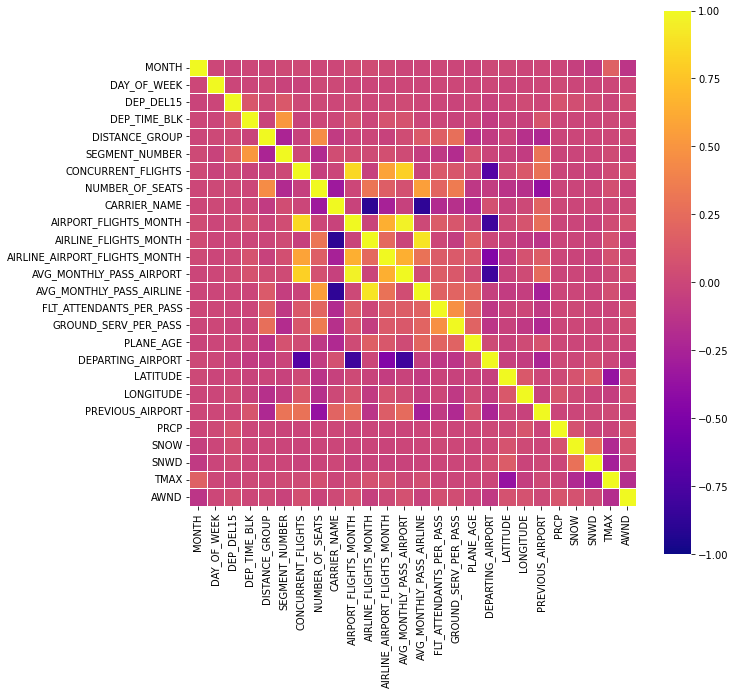

In [15]:
fig, ax = plt.subplots(figsize=(10,10))

corr_mat = df.corr()
sns.heatmap(corr_mat, square=True, cmap='plasma', linewidths=.5, ax=ax, vmin = -1, vmax = 1)
pass

In [16]:
corr_mat['DEP_DEL15']

MONTH                           -0.019049
DAY_OF_WEEK                     -0.000199
DEP_DEL15                        1.000000
DEP_TIME_BLK                     0.109707
DISTANCE_GROUP                   0.016289
SEGMENT_NUMBER                   0.117528
CONCURRENT_FLIGHTS               0.009028
NUMBER_OF_SEATS                  0.011845
CARRIER_NAME                     0.002282
AIRPORT_FLIGHTS_MONTH            0.026740
AIRLINE_FLIGHTS_MONTH            0.003528
AIRLINE_AIRPORT_FLIGHTS_MONTH    0.013711
AVG_MONTHLY_PASS_AIRPORT         0.024383
AVG_MONTHLY_PASS_AIRLINE         0.001257
FLT_ATTENDANTS_PER_PASS         -0.002114
GROUND_SERV_PER_PASS            -0.016736
PLANE_AGE                        0.006220
DEPARTING_AIRPORT               -0.037350
LATITUDE                         0.000490
LONGITUDE                        0.027097
PREVIOUS_AIRPORT                 0.001224
PRCP                             0.080277
SNOW                             0.050156
SNWD                             0

Избавляемся от данных, зависимость от которых мала

In [17]:
df = df.drop(['DAY_OF_WEEK', 'CARRIER_NAME', 'AIRLINE_FLIGHTS_MONTH', 'AVG_MONTHLY_PASS_AIRLINE', 'FLT_ATTENDANTS_PER_PASS', 'PLANE_AGE', 'LATITUDE', 'TMAX', 'CONCURRENT_FLIGHTS', 'PREVIOUS_AIRPORT'], axis = 1)
df

,MONTH,DEP_DEL15,DEP_TIME_BLK,DISTANCE_GROUP,SEGMENT_NUMBER,NUMBER_OF_SEATS,AIRPORT_FLIGHTS_MONTH,AIRLINE_AIRPORT_FLIGHTS_MONTH,AVG_MONTHLY_PASS_AIRPORT,GROUND_SERV_PER_PASS,DEPARTING_AIRPORT,LONGITUDE,PRCP,SNOW,SNWD,AWND
0,1,0,0,2,1,143,13056,5873,1903352,0.000099,10,-115.152,0.00,0.0,0.0,2.91
1,1,0,1,7,1,191,13056,1174,1903352,0.000149,10,-115.152,0.00,0.0,0.0,2.91
2,1,0,2,7,1,199,13056,1174,1903352,0.000149,10,-115.152,0.00,0.0,0.0,2.91
3,1,0,2,9,1,180,13056,1174,1903352,0.000149,10,-115.152,0.00,0.0,0.0,2.91
4,1,0,17,7,1,182,13056,1257,1903352,0.000125,10,-115.152,0.00,0.0,0.0,2.91
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6489057,12,0,18,1,11,123,1318,757,133573,0.000198,86,-159.346,0.06,0.0,0.0,15.21
6489058,12,0,10,1,11,123,1318,757,133573,0.000198,86,-159.346,0.06,0.0,0.0,15.21
6489059,12,0,14,1,11,123,1318,757,133573,0.000198,86,-159.346,0.06,0.0,0.0,15.21
6489060,12,0,15,1,12,123,1318,757,133573,0.000198,86,-159.346,0.06,0.0,0.0,15.21


Больше всего самолетов отменяют в июне(относительно общего числа полетов)

Text(0, 0.5, 'Departure Delays')

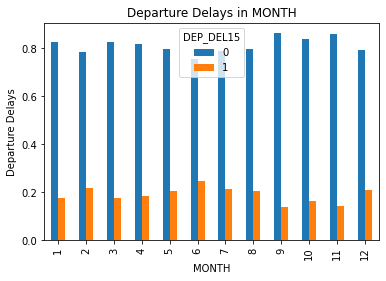

In [18]:
pd.crosstab(data.MONTH, data.DEP_DEL15, normalize='index' ).plot(kind='bar')
plt.title('Departure Delays in MONTH')
plt.xlabel('MONTH')
plt.ylabel('Departure Delays')

Text(0, 0.5, 'Departure Delays')

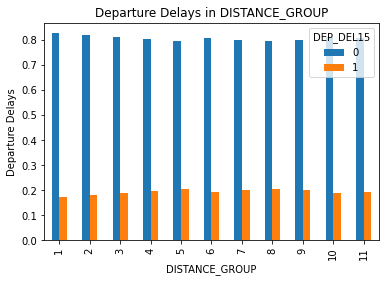

In [14]:
pd.crosstab(data.DISTANCE_GROUP, data.DEP_DEL15, normalize='index' ).plot(kind='bar')
plt.title('Departure Delays in DISTANCE_GROUP')
plt.xlabel('DISTANCE_GROUP')
plt.ylabel('Departure Delays')

Text(0, 0.5, 'Departure Delays')

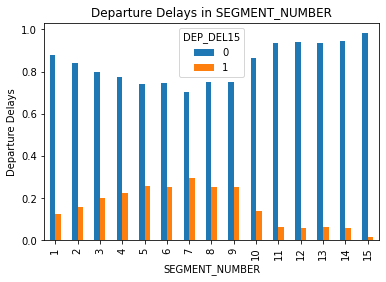

In [15]:
pd.crosstab(data.SEGMENT_NUMBER, data.DEP_DEL15, normalize='index' ).plot(kind='bar')
plt.title('Departure Delays in SEGMENT_NUMBER')
plt.xlabel('SEGMENT_NUMBER')
plt.ylabel('Departure Delays')

Сбалансируем классы, для чего возьмем количество записей равное наименьшему классу для каждого из классов

In [16]:
c2 = df[df['DEP_DEL15'] == 1]
c1 = df[df['DEP_DEL15'] == 0]
req = int(min(c2.size, c1.size) / 16)
df_2 = c2.sample(req)
df_1 = c1.sample(req)
df = pd.concat([df_2,df_1],axis=0)

In [17]:
X = df.drop('DEP_DEL15', axis = 1)
y = df['DEP_DEL15']

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=17)

In [23]:
X_train

,MONTH,DEP_TIME_BLK,DISTANCE_GROUP,SEGMENT_NUMBER,NUMBER_OF_SEATS,AIRPORT_FLIGHTS_MONTH,AIRLINE_AIRPORT_FLIGHTS_MONTH,AVG_MONTHLY_PASS_AIRPORT,GROUND_SERV_PER_PASS,DEPARTING_AIRPORT,LONGITUDE,PRCP,SNOW,SNWD,AWND
5423574,11,8,2,5,143,13136,5048,1903352,0.000099,10,-115.152,0.00,0.0,0.0,3.58
676472,2,8,4,1,160,7168,4218,1413432,0.000177,24,-80.286,0.76,0.0,0.0,8.05
3806349,8,15,10,1,181,19609,1816,2780593,0.000175,5,-118.408,0.00,0.0,0.0,7.83
3620699,7,3,4,5,70,1189,395,96822,0.000099,84,-89.337,1.91,0.0,0.0,8.50
6381139,12,7,2,2,143,7211,2550,874468,0.000099,27,-82.535,0.00,0.0,0.0,3.58
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1290577,3,14,8,6,180,2963,83,289569,0.000007,49,-81.688,0.00,0.0,0.0,6.26
1641919,4,12,5,5,128,7011,3942,1413432,0.000177,24,-80.286,0.00,0.0,0.0,7.83
5699140,11,3,7,5,143,20118,5783,2743323,0.000099,3,-104.880,0.00,0.0,0.0,9.62
295305,1,7,2,3,70,1891,196,191927,0.000107,56,-89.979,0.00,0.0,0.0,10.96


Классификация с помощью метода k-nearest neighbors

In [21]:
# neighbors = np.arange(1,7)
# train = []
# test = []
# for i,k in enumerate(neighbors):
#     knn = Pipeline([('scaler', StandardScaler()), ('classifier', KNeighborsClassifier(n_neighbors=k, n_jobs=-1))])
#     knn.fit(X_train, y_train)
#     train.append(knn.score(X_train, y_train))
#     test.append(knn.score(X_test, y_test))
#     print(f'{k} done')

In [22]:
# plt.plot(np.arange(1,7), train)
# plt.plot(np.arange(1,7), test)
# max(test)

In [23]:
knn = Pipeline([('scaler', StandardScaler()), ('classifier', KNeighborsClassifier(n_neighbors=6, n_jobs=-1))])
knn.fit(X_train, y_train)
predict = knn.predict(X_test)
target_names = ['Not Delay', 'Delay']
print(classification_report(predict, y_test, target_names=target_names))

              precision    recall  f1-score   support

   Not Delay       0.74      0.59      0.66    457200
       Delay       0.50      0.65      0.56    279221

    accuracy                           0.62    736421
   macro avg       0.62      0.62      0.61    736421
weighted avg       0.65      0.62      0.62    736421



c:\Users\dimar\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


<function matplotlib.pyplot.show(close=None, block=None)>

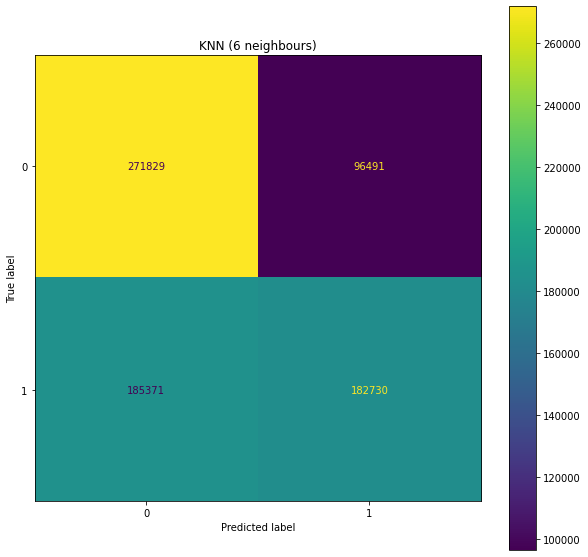

In [24]:
fig, ax = plt.subplots(figsize=(10,10))
ax.set_title(f'KNN (6 neighbours)')
cm = confusion_matrix()
ConfusionMatrixDisplay.from_estimator(knn, X_test,y_test, ax=ax)  
plt.show

Классификация с помощью логистической регрессии

In [25]:
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

In [26]:
predict = model.predict(X_test)
target_names = ['Not Delay', 'Delay']
print(classification_report(predict, y_test, target_names=target_names))

              precision    recall  f1-score   support

   Not Delay       0.05      0.51      0.09     33921
       Delay       0.95      0.50      0.66    702500

    accuracy                           0.50    736421
   macro avg       0.50      0.51      0.37    736421
weighted avg       0.91      0.50      0.63    736421



c:\Users\dimar\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


<function matplotlib.pyplot.show(close=None, block=None)>

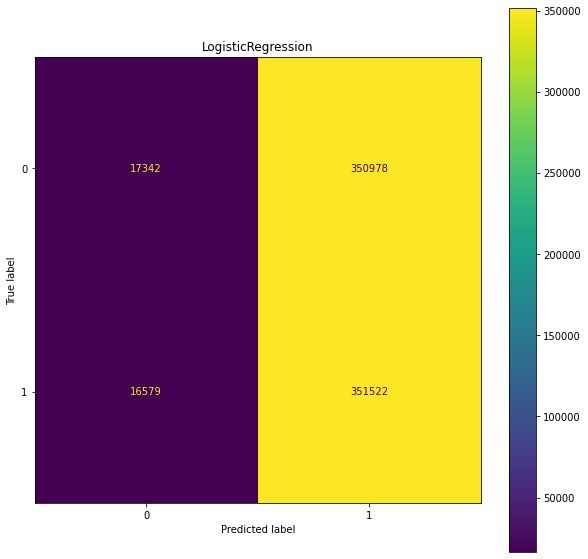

In [27]:
fig, ax = plt.subplots(figsize=(10,10))
ax.set_title(f'LogisticRegression')
ConfusionMatrixDisplay.from_estimator(model, X_test,y_test, ax=ax)  
plt.show

In [28]:
model = LogisticRegression(class_weight='balanced')
model.fit(X_train, y_train)
predict = model.predict(X_test)
target_names = ['Not Delay', 'Delay']
print(classification_report(predict, y_test, target_names=target_names))

              precision    recall  f1-score   support

   Not Delay       0.05      0.51      0.09     34176
       Delay       0.95      0.50      0.66    702245

    accuracy                           0.50    736421
   macro avg       0.50      0.51      0.37    736421
weighted avg       0.91      0.50      0.63    736421



c:\Users\dimar\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


<function matplotlib.pyplot.show(close=None, block=None)>

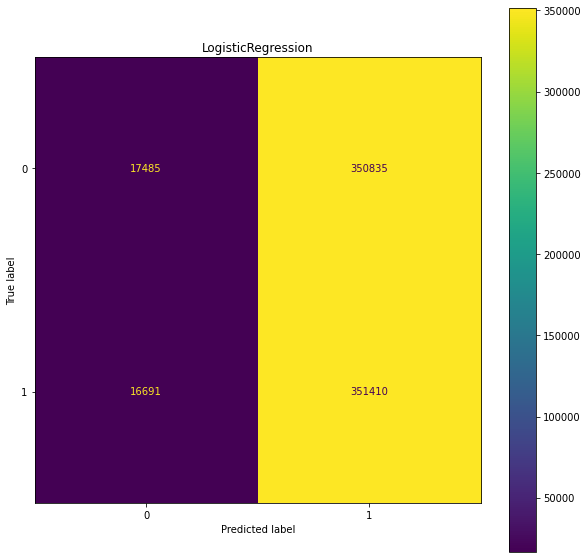

In [29]:
fig, ax = plt.subplots(figsize=(10,10))
ax.set_title(f'LogisticRegression')
ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, ax=ax)  
plt.show

Классификация на полных данных, по наиболее каррелируемым признакам

In [68]:
X = tdf[["TMAX","PRCP","SNOW","CARRIER_NAME","SNWD","AWND","CONCURRENT_FLIGHTS","DEP_TIME_BLK","DEPARTING_AIRPORT","FLT_ATTENDANTS_PER_PASS","NUMBER_OF_SEATS"]] #"TMAX","CARRIER_NAME","CONCURRENT_FLIGHTS","FLT_ATTENDANTS_PER_PASS"
y = tdf["DEP_DEL15"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=21)

In [31]:
model = LogisticRegression()
model.fit(X_train, y_train)

c:\Users\dimar\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [32]:
predict = model.predict(X_test)
target_names = ['Not Delay', 'Delay']
print(classification_report(predict, y_test, target_names=target_names))

              precision    recall  f1-score   support

   Not Delay       1.00      0.81      0.90   1291694
       Delay       0.01      0.45      0.02      6119

    accuracy                           0.81   1297813
   macro avg       0.50      0.63      0.46   1297813
weighted avg       0.99      0.81      0.89   1297813



c:\Users\dimar\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


<function matplotlib.pyplot.show(close=None, block=None)>

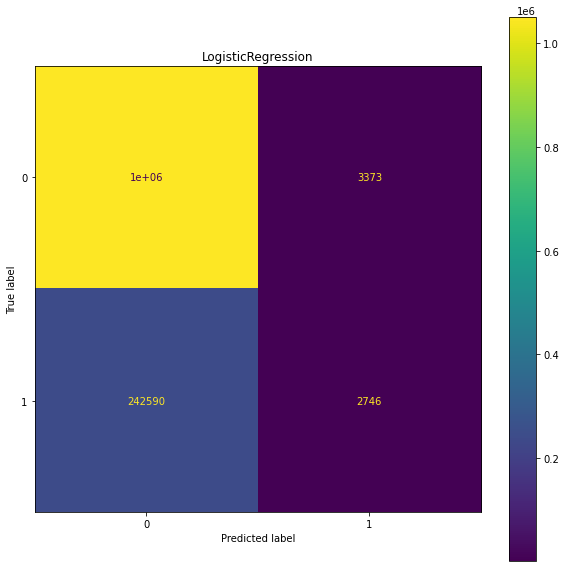

In [33]:
fig, ax = plt.subplots(figsize=(10,10))
ax.set_title(f'LogisticRegression')
ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, ax=ax)  
plt.show

In [34]:
model = LogisticRegression(class_weight='balanced')
model.fit(X_train, y_train)
predict = model.predict(X_test)
target_names = ['Not Delay', 'Delay']
print(classification_report(predict, y_test, target_names=target_names))

c:\Users\dimar\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score   support

   Not Delay       0.59      0.85      0.70    725887
       Delay       0.57      0.24      0.34    571926

    accuracy                           0.58   1297813
   macro avg       0.58      0.55      0.52   1297813
weighted avg       0.58      0.58      0.54   1297813



c:\Users\dimar\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


<function matplotlib.pyplot.show(close=None, block=None)>

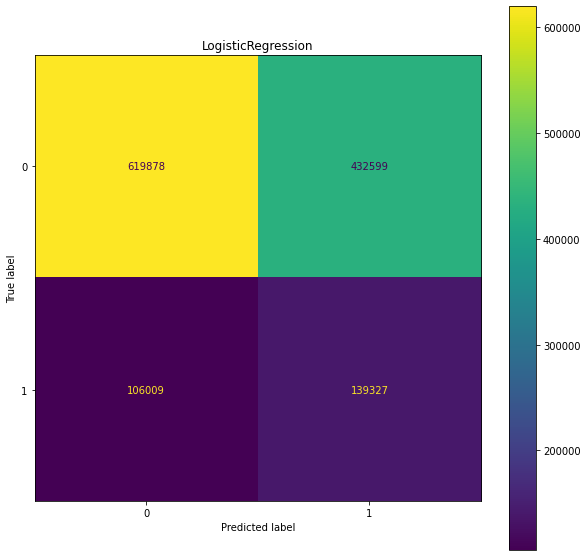

In [35]:
fig, ax = plt.subplots(figsize=(10,10))
ax.set_title(f'LogisticRegression')
ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, ax=ax)  
plt.show

In [36]:
knn = Pipeline([('scaler', StandardScaler()), ('classifier', KNeighborsClassifier(n_neighbors=6, n_jobs=-1))])
knn.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('classifier', KNeighborsClassifier(n_jobs=-1, n_neighbors=6))])

In [37]:
predict = knn.predict(X_test)
target_names = ['Not Delay', 'Delay']
print(classification_report(predict, y_test, target_names=target_names))

              precision    recall  f1-score   support

   Not Delay       0.97      0.83      0.89   1232490
       Delay       0.14      0.52      0.22     65323

    accuracy                           0.81   1297813
   macro avg       0.55      0.67      0.56   1297813
weighted avg       0.93      0.81      0.86   1297813



c:\Users\dimar\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


<function matplotlib.pyplot.show(close=None, block=None)>

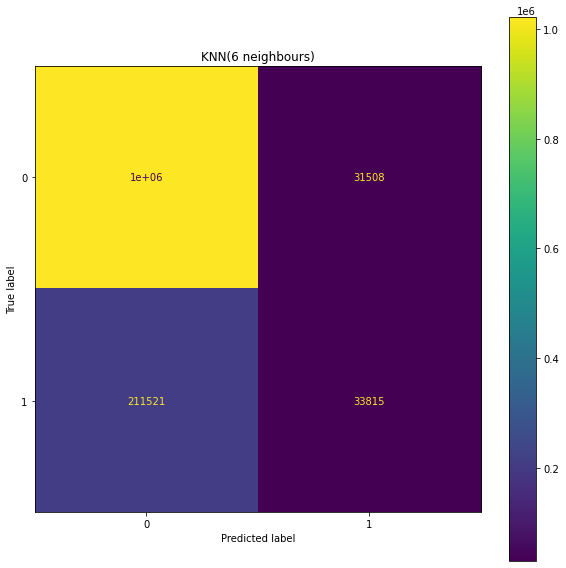

In [38]:
fig, ax = plt.subplots(figsize=(10,10))
ax.set_title(f'KNN(6 neighbours)')
ConfusionMatrixDisplay.from_estimator(knn, X_test, y_test, ax=ax)  
plt.show

Стандартизация данных:

Избавляемся от выбросов

In [19]:
tdf_f = tdf.drop(['DAY_OF_WEEK', 'CARRIER_NAME', 'AIRLINE_FLIGHTS_MONTH', 'AVG_MONTHLY_PASS_AIRLINE', 'FLT_ATTENDANTS_PER_PASS', 'PLANE_AGE', 'LATITUDE', 'TMAX', 'CONCURRENT_FLIGHTS', 'PREVIOUS_AIRPORT'], axis = 1)

In [20]:
ncols = np.clip(len(tdf_f.columns), 0, 16)
cols = tdf_f.columns[:ncols]
drop = (tdf_f[cols[0]] < tdf_f[cols[0]].quantile(0.005)) | (tdf_f[cols[0]] > tdf_f[cols[0]].quantile(0.995))
for i in range(1, ncols):
    drop = drop | (tdf_f[cols[i]] < tdf_f[cols[i]].quantile(0.005)) | (tdf_f[cols[i]] > tdf_f[cols[i]].quantile(0.995))
rtd = tdf_f[drop].index
df_clear = tdf_f.drop(index = rtd)

In [21]:
c2 = df_clear[df_clear['DEP_DEL15'] == 1]
c1 = df_clear[df_clear['DEP_DEL15'] == 0]
req = int(min(c2.size, c1.size) / 16)
df_2 = c2.sample(req)
df_1 = c1.sample(req)
df_clear = pd.concat([df_2,df_1],axis=0)

In [22]:
from sklearn.preprocessing import Normalizer
X = df_clear.drop('DEP_DEL15', axis = 1)
y = df_clear['DEP_DEL15']
transformer = Normalizer().fit(X)
X_normalize = transformer.transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_normalize,y, test_size=0.3, random_state=17)

In [23]:
# neighbors = np.arange(1,7)
# train = []
# test = []
# for i,k in enumerate(neighbors):
#     knn = KNeighborsClassifier(n_neighbors=k, n_jobs=-1)
#     knn.fit(X_train, y_train)
#     train.append(knn.score(X_train, y_train))
#     test.append(knn.score(X_test, y_test))
#     print(f'{k} done')

1 done
2 done
3 done
4 done
5 done
6 done


0.6094543637469112

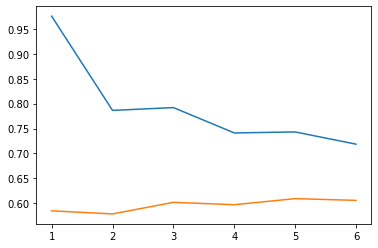

In [24]:
# plt.plot(np.arange(1,7), train)
# plt.plot(np.arange(1,7), test)
# max(test)

In [73]:
knn = KNeighborsClassifier(n_neighbors=6, n_jobs=-1)
knn.fit(X_train, y_train)
predict = knn.predict(X_test)
target_names = ['Not Delay', 'Delay']
print(classification_report(predict, y_test, target_names=target_names))

              precision    recall  f1-score   support

   Not Delay       0.73      0.59      0.65    429450
       Delay       0.49      0.64      0.55    262971

    accuracy                           0.61    692421
   macro avg       0.61      0.61      0.60    692421
weighted avg       0.63      0.61      0.61    692421



c:\Users\dimar\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


<function matplotlib.pyplot.show(close=None, block=None)>

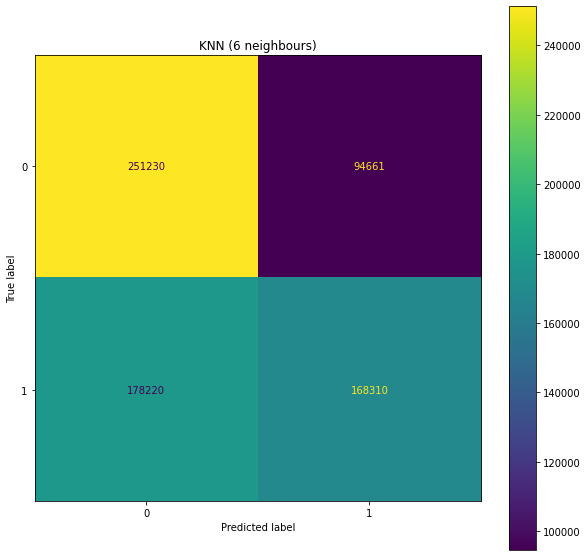

In [74]:
fig, ax = plt.subplots(figsize=(10,10))
ax.set_title(f'KNN (6 neighbours)')
ConfusionMatrixDisplay.from_estimator(knn, X_test,y_test, ax=ax)  
plt.show

In [23]:
model = LogisticRegression(class_weight='balanced', solver='newton-cholesky')
model.fit(X_train, y_train)
predict = model.predict(X_test)
target_names = ['Not Delay', 'Delay']
print(classification_report(predict, y_test, target_names=target_names))

              precision    recall  f1-score   support

   Not Delay       0.56      0.51      0.53    379939
       Delay       0.46      0.51      0.49    312482

    accuracy                           0.51    692421
   macro avg       0.51      0.51      0.51    692421
weighted avg       0.52      0.51      0.51    692421



<function matplotlib.pyplot.show(close=None, block=None)>

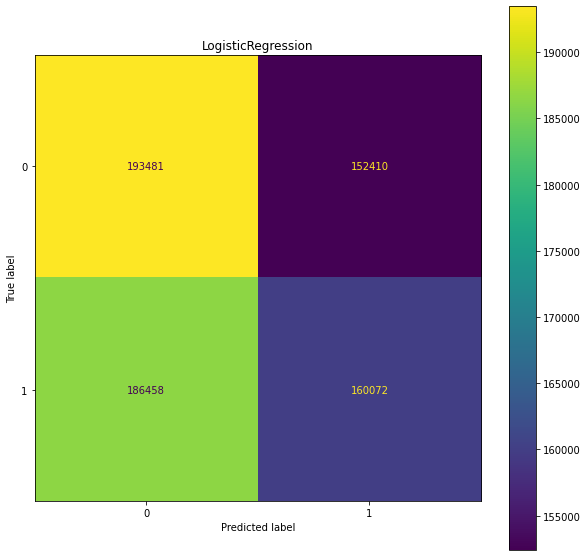

In [24]:
fig, ax = plt.subplots(figsize=(10,10))
ax.set_title(f'LogisticRegression')
ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, ax=ax)  
plt.show

Стандартизация данных

In [25]:
transformer = StandardScaler().fit(X)
X_scaler = transformer.transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaler,y, test_size=0.3, random_state=17)

In [30]:
# neighbors = np.arange(1,7)
# train = []
# test = []
# for i,k in enumerate(neighbors):
#     knn = KNeighborsClassifier(n_neighbors=k, n_jobs=-1)
#     knn.fit(X_train, y_train)
#     train.append(knn.score(X_train, y_train))
#     test.append(knn.score(X_test, y_test))
#     print(f'{k} done')

In [31]:
# plt.plot(np.arange(1,7), train)
# plt.plot(np.arange(1,7), test)
# max(test)

In [32]:
knn = KNeighborsClassifier(n_neighbors=6, n_jobs=-1)
knn.fit(X_train, y_train)
predict = knn.predict(X_test)
target_names = ['Not Delay', 'Delay']
print(classification_report(predict, y_test, target_names=target_names))

              precision    recall  f1-score   support

   Not Delay       0.73      0.59      0.66    429794
       Delay       0.49      0.65      0.56    262627

    accuracy                           0.61    692421
   macro avg       0.61      0.62      0.61    692421
weighted avg       0.64      0.61      0.62    692421



c:\Users\dimar\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


<function matplotlib.pyplot.show(close=None, block=None)>

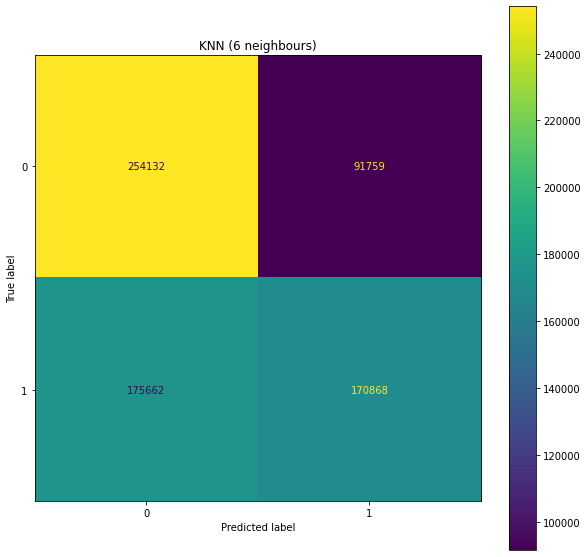

In [33]:
fig, ax = plt.subplots(figsize=(10,10))
ax.set_title(f'KNN (6 neighbours)')
ConfusionMatrixDisplay.from_estimator(knn, X_test,y_test, ax=ax)  
plt.show

In [28]:
model = LogisticRegression(class_weight='balanced', solver= 'newton-cholesky')
model.fit(X_train, y_train)
predict = model.predict(X_test)
target_names = ['Not Delay', 'Delay']
print(classification_report(predict, y_test, target_names=target_names))

              precision    recall  f1-score   support

   Not Delay       0.61      0.59      0.60    359931
       Delay       0.57      0.59      0.58    332490

    accuracy                           0.59    692421
   macro avg       0.59      0.59      0.59    692421
weighted avg       0.59      0.59      0.59    692421



<function matplotlib.pyplot.show(close=None, block=None)>

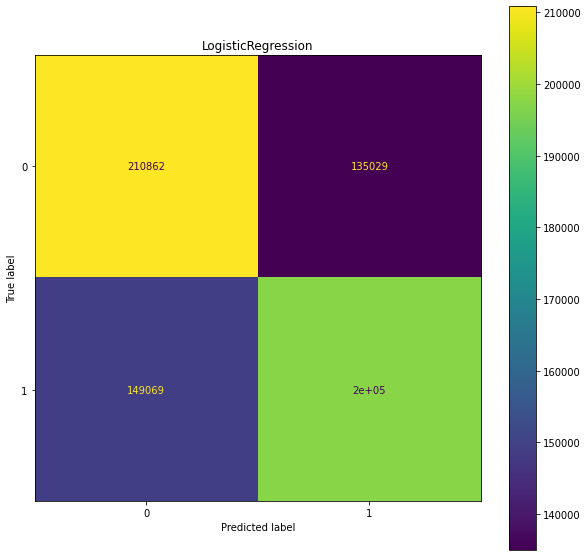

In [29]:
fig, ax = plt.subplots(figsize=(10,10))
ax.set_title(f'LogisticRegression')
ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, ax=ax)  
plt.show

In [37]:
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler

MinMaxScaler

In [38]:
transformer = MinMaxScaler().fit(X)
X_scaler = transformer.transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaler,y, test_size=0.3, random_state=17)

In [39]:
model = LogisticRegression(class_weight='balanced')
model.fit(X_train, y_train)
predict = model.predict(X_test)
target_names = ['Not Delay', 'Delay']
print(classification_report(predict, y_test, target_names=target_names))

              precision    recall  f1-score   support

   Not Delay       0.61      0.59      0.60    358829
       Delay       0.57      0.60      0.58    333592

    accuracy                           0.59    692421
   macro avg       0.59      0.59      0.59    692421
weighted avg       0.59      0.59      0.59    692421



c:\Users\dimar\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


<function matplotlib.pyplot.show(close=None, block=None)>

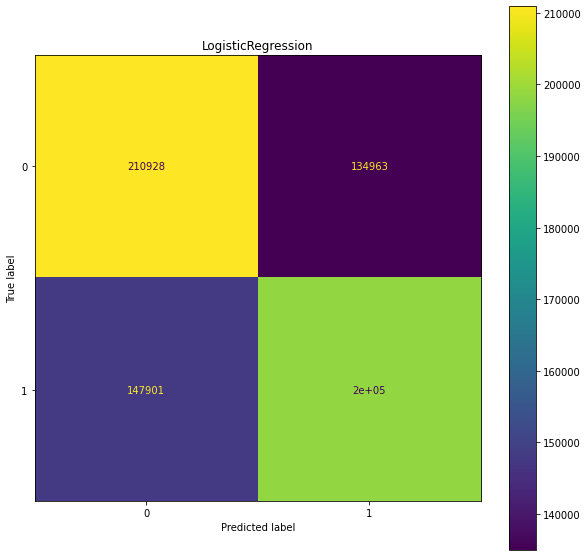

In [40]:
fig, ax = plt.subplots(figsize=(10,10))
ax.set_title(f'LogisticRegression')
ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, ax=ax)  
plt.show

MaxAbsScaler

In [41]:
transformer = MaxAbsScaler().fit(X)
X_scaler = transformer.transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaler,y, test_size=0.3, random_state=17)

In [51]:
model = LogisticRegression(class_weight='balanced')
model.fit(X_train, y_train)
predict = model.predict(X_test)
target_names = ['Not Delay', 'Delay']
print(classification_report(predict, y_test, target_names=target_names))

              precision    recall  f1-score   support

   Not Delay       0.61      0.59      0.60    358834
       Delay       0.57      0.60      0.58    333587

    accuracy                           0.59    692421
   macro avg       0.59      0.59      0.59    692421
weighted avg       0.59      0.59      0.59    692421



c:\Users\dimar\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


<function matplotlib.pyplot.show(close=None, block=None)>

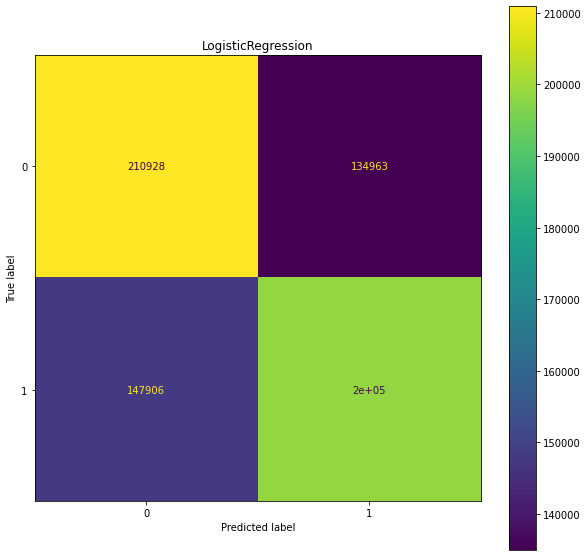

In [52]:
fig, ax = plt.subplots(figsize=(10,10))
ax.set_title(f'LogisticRegression')
ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, ax=ax)  
plt.show

In [30]:
from sklearn.neural_network import MLPClassifier

In [38]:
#MLPClassifier()
train = []
test = []
layers = np.arange(15, 101, 5)
for k in layers:
    clf = MLPClassifier(hidden_layer_sizes = (k, ), random_state=17, max_iter=500)
    clf.fit(X_train, y_train)
    train.append(clf.score(X_train, y_train))
    test.append(clf.score(X_test, y_test))
    print(f'{k} done')

15 done
20 done
25 done
30 done
35 done
40 done
45 done
50 done
55 done
60 done
65 done
70 done
75 done
80 done
85 done
90 done
95 done
100 done


0.6360841164551624

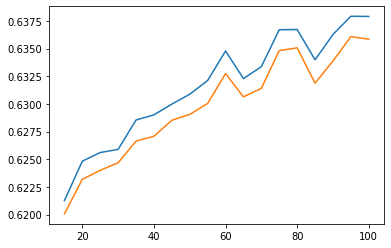

In [39]:
plt.plot(layers, train)
plt.plot(layers, test)
max(test)

In [90]:
#[[i, j, k, l] for i in range(30, 51, 20) for j in range(30, 51, 20) for k in range(30, 51, 20) for l in range(30, 51, 20)]

In [91]:
MLPclass = MLPClassifier()
layers = [[i] for i in range(10, 31, 10)]+[[i, j] for i in range(10, 31, 10) for j in range(10, 31, 10)]
parameters = {'hidden_layer_sizes': layers}
clf = GridSearchCV(MLPclass, parameters, n_jobs = -1)
report = clf.fit(X_train, y_train)

In [92]:
target_names = ['Not Delay', 'Delay']
predict = clf.best_estimator_.predict(X_test)
print(classification_report(predict, y_test, target_names=target_names))

              precision    recall  f1-score   support

   Not Delay       0.62      0.64      0.63    336278
       Delay       0.65      0.64      0.64    356143

    accuracy                           0.64    692421
   macro avg       0.64      0.64      0.64    692421
weighted avg       0.64      0.64      0.64    692421



<function matplotlib.pyplot.show(close=None, block=None)>

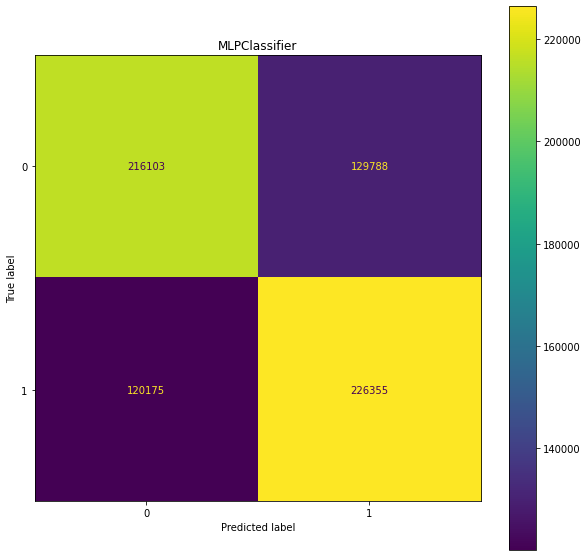

In [93]:
fig, ax = plt.subplots(figsize=(10,10))
ax.set_title(f'MLPClassifier')
ConfusionMatrixDisplay.from_estimator(clf.best_estimator_, X_test, y_test, ax=ax)  
plt.show

In [94]:
clf.best_estimator_

MLPClassifier(hidden_layer_sizes=[30, 30, 50, 30])

In [76]:
MLPclass = MLPClassifier(hidden_layer_sizes= [30, 30, 30, 30]).fit(X_train,y_train)
predict = MLPclass.predict(X_test)
print(classification_report(predict, y_test, target_names=target_names))

              precision    recall  f1-score   support

   Not Delay       0.63      0.64      0.64    342594
       Delay       0.64      0.64      0.64    349827

    accuracy                           0.64    692421
   macro avg       0.64      0.64      0.64    692421
weighted avg       0.64      0.64      0.64    692421



<function matplotlib.pyplot.show(close=None, block=None)>

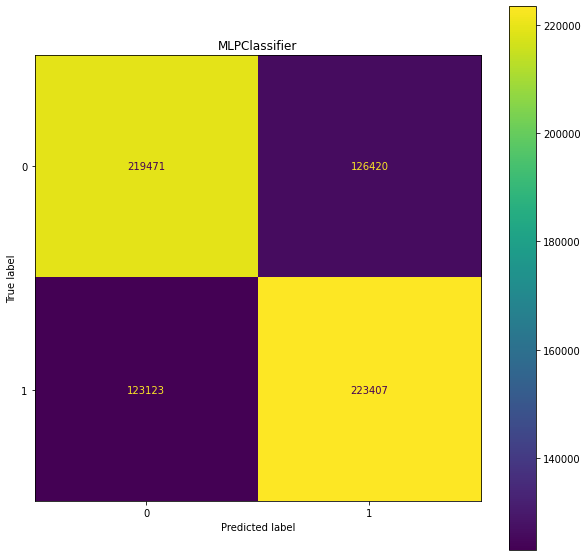

In [77]:
fig, ax = plt.subplots(figsize=(10,10))
ax.set_title(f'MLPClassifier')
ConfusionMatrixDisplay.from_estimator(MLPclass, X_test, y_test, ax=ax)  
plt.show

In [74]:
MLPclass = MLPClassifier(hidden_layer_sizes= [40, 40, 40, 40], activation= 'logistic').fit(X_train,y_train)
predict = MLPclass.predict(X_test)
print(classification_report(predict, y_test, target_names=target_names))

              precision    recall  f1-score   support

   Not Delay       0.62      0.65      0.63    331894
       Delay       0.66      0.64      0.65    360527

    accuracy                           0.64    692421
   macro avg       0.64      0.64      0.64    692421
weighted avg       0.64      0.64      0.64    692421



<function matplotlib.pyplot.show(close=None, block=None)>

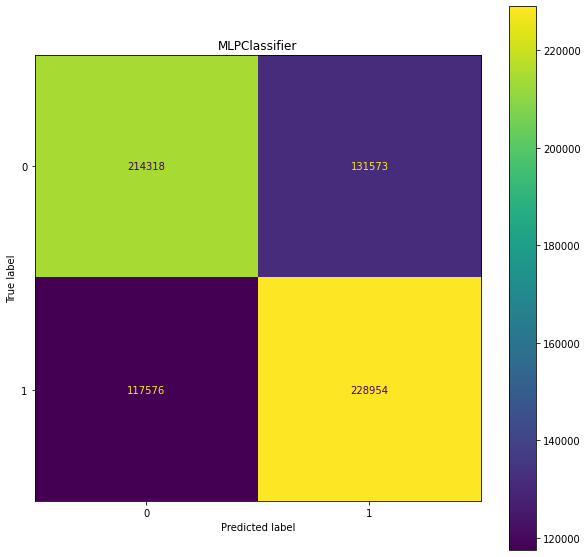

In [75]:
fig, ax = plt.subplots(figsize=(10,10))
ax.set_title(f'MLPClassifier')
ConfusionMatrixDisplay.from_estimator(MLPclass, X_test, y_test, ax=ax)  
plt.show